# Detect Anomalies Using Density Based Clustering  (DBSCAN)

## Exercises

Reference: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html?highlight=dbscan

In [1]:
# Import libraries
import  pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import  metrics
import  env
from matplotlib import style
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from wrangle import parse_curriculum_access_data, parse_grocery_data
# DBSCAN import
from sklearn.cluster import DBSCAN

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

sns.set(rc={'figure.figsize':(13,6)})


### NOTES:

- #### Using density based clustering, like DBSCAN, we can design the model such that the data points that do not fall into a cluster are the anomalies.
- #### Assumption: Data points that are similar tend to belong to similar groups or clusters, as determined by their distance from local centroids. Normal data points occur around a dense neighborhood and abnormalities are far away.


### Steps: 

1. Select variables you want to cluster: 
        df = df[["col1", "col2"]]
2. Convert to array & dtype float: 
        np_array = df.values.astype("float32", copy = False)
3. Scale to standard normal:
        scaler = StandardScaler().fit(np_array) np_array = scaler.transform(np_array)
4. Create DBSCAN object and fit: 
        dbsc = DBSCAN(eps = .75, min_samples = 15).fit(np_array)
5. Extract labels: 
        labels = dbsc.labels_
6. Add labels back to original dataframe:
        df['labels'] = labels
7. Explore:
        df.labels.value_counts() sns.scatterplot(df.col1, df.col2, hue=df.labels)

### A. Grocery Data Clustering Anomalies Detection

Use DBSCAN to detect anomalies in other products from the customers dataset. The database name is grocery_db.

In [2]:
# Acquire the data
df = parse_grocery_data()
df.head()

Getting grocery data from local machine..


,channel,region,fresh,milk,grocery,frozen,detergents_paper,delicassen
customer_id,,,,,,,,
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


#### Variables to cluster

In [3]:
frozen_grocery_detergent_delicassen = df[['frozen','grocery','detergents_paper','delicassen']]
frozen_grocery_detergent_delicassen.head()

,frozen,grocery,detergents_paper,delicassen
customer_id,,,,
0,214,7561,2674,1338
1,1762,9568,3293,1776
2,2405,7684,3516,7844
3,6404,4221,507,1788
4,3915,7198,1777,5185


##### Normalize each attribute by scaling it to 0 mean and unit variance. 
    - This helps to keep the inter-relationships between the features intact so that a small change in one feature would reflect in the other.

In [4]:
# Call the scaler
scaler = MinMaxScaler()

# Fit the scaler
scaler.fit(frozen_grocery_detergent_delicassen)

# # Use scaler
frozen_grocery_detergent_delicassen = scaler.transform(frozen_grocery_detergent_delicassen)
frozen_grocery_detergent_delicassen

array([[0.0031063 , 0.08146416, 0.0654272 , 0.02784731],
       [0.02854842, 0.10309667, 0.08058985, 0.03698373],
       [0.03911643, 0.08278992, 0.08605232, 0.16355861],
       ...,
       [0.00677142, 0.32594285, 0.36346267, 0.03888194],
       [0.01664914, 0.02402535, 0.00404174, 0.04426366],
       [0.00065742, 0.02702178, 0.01161082, 0.00102211]])

#### NOTE: Construct a DBSCAN object that requires a minimum of 20 data points in a neighborhood of radius 0.1 to be considered a core point.

> ##### Eps --> The maximum distance between two samples for one to be considered as in the neighborhood of the other

In [5]:
# Create DBSCAN object
dbsc = DBSCAN(eps = 0.1, min_samples = 20)
# Fit dbscan object
dbsc.fit(frozen_grocery_detergent_delicassen)

DBSCAN(eps=0.1, min_samples=20)

#### Concat to main df scaled db

In [6]:
cols = ['frozen','grocery','detergents_paper','delicassen']
scaled_cols = ['scaled_'+ col for col in cols]

# Save copy of main df
save_original_df = df.copy()

scaled_df = pd.DataFrame(frozen_grocery_detergent_delicassen, columns = scaled_cols)

# Merge scaled and non-scaled cols
df = df.merge(scaled_df, on = df.index)
df = df.drop(columns = ['key_0'])
df.head()

,channel,region,fresh,milk,grocery,frozen,detergents_paper,delicassen,scaled_frozen,scaled_grocery,scaled_detergents_paper,scaled_delicassen
0,2,3,12669,9656,7561,214,2674,1338,0.003106,0.081464,0.065427,0.027847
1,2,3,7057,9810,9568,1762,3293,1776,0.028548,0.103097,0.080590,0.036984
2,2,3,6353,8808,7684,2405,3516,7844,0.039116,0.082790,0.086052,0.163559
3,1,3,13265,1196,4221,6404,507,1788,0.104842,0.045464,0.012346,0.037234
4,2,3,22615,5410,7198,3915,1777,5185,0.063934,0.077552,0.043455,0.108093


#### Next, extract our cluster labels and outliers to plot our results.
- DBSCAN makes a cluster called -1 that contains the "noise" or outliers
- Cluster labels do not have inherent meaning

> ### 0 --> 'Inliers'
> ### -1 --> 'Outliers'


In [7]:
# Get labels from cluster model

df['labels'] = dbsc.labels_
# Count
df.labels.value_counts()

 0    413
-1     27
Name: labels, dtype: int64

#### Plots

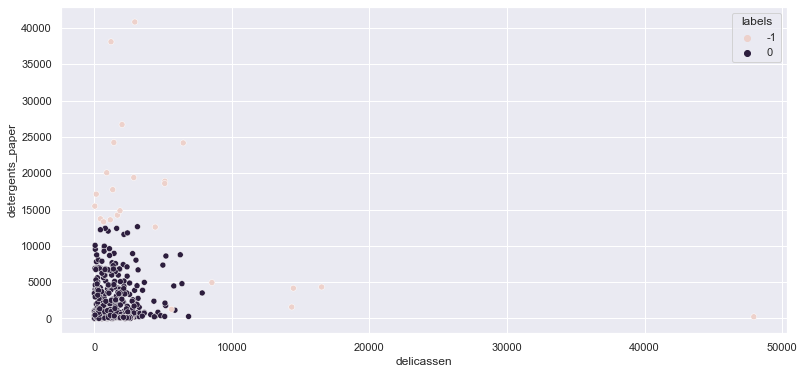

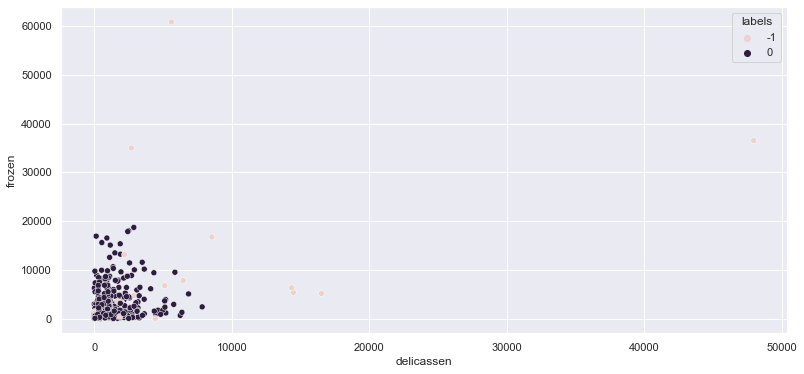

In [8]:
sns.scatterplot(df.delicassen, df.detergents_paper, hue = df.labels)
plt.show()

sns.scatterplot(df.delicassen, df.frozen, hue = df.labels)
plt.show()

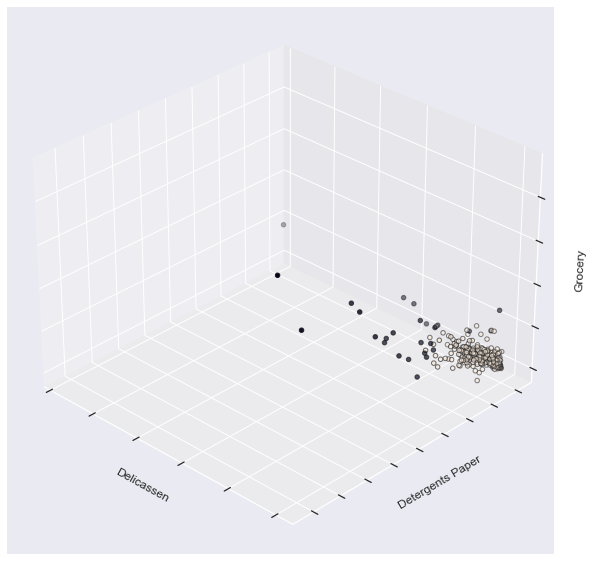

In [9]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(1, figsize=(8, 8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=30, azim=134)

# plot the points
ax.scatter(df.delicassen, df.detergents_paper, df.grocery,
           c=df.labels, edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

ax.set_xlabel('Delicassen')
ax.set_ylabel('Detergents Paper')
ax.set_zlabel('Grocery')
None

### Inlier, populationa and outliers

In [10]:
# Let's look at the descriptive stats for the entire population, the inliers, then the outliers/anomalies

print("Population")
print(df.describe())
print("-------------")
print("Inliers")
print(df[df.labels==0].describe())
print("-------------")
print("Outliers")
print(df[df.labels==-1].describe())

Population
          channel      region          fresh          milk       grocery  \
count  440.000000  440.000000     440.000000    440.000000    440.000000   
mean     1.322727    2.543182   12000.297727   5796.265909   7951.277273   
std      0.468052    0.774272   12647.328865   7380.377175   9503.162829   
min      1.000000    1.000000       3.000000     55.000000      3.000000   
25%      1.000000    2.000000    3127.750000   1533.000000   2153.000000   
50%      1.000000    3.000000    8504.000000   3627.000000   4755.500000   
75%      2.000000    3.000000   16933.750000   7190.250000  10655.750000   
max      2.000000    3.000000  112151.000000  73498.000000  92780.000000   

             frozen  detergents_paper    delicassen  scaled_frozen  \
count    440.000000        440.000000    440.000000     440.000000   
mean    3071.931818       2881.493182   1524.870455       0.050078   
std     4854.673333       4767.854448   2820.105937       0.079789   
min       25.000000     

### B. Curriculum Logs Clustering Anomalies Detection 

Use DBSCAN to detect anomalies in requests from the curriculum access logs in the curriculum_logs database.

In [2]:
df = parse_curriculum_access_data()
df.head()

,time,page,id,cohort,ip
date,,,,,
2018-01-26,09:55:03,/,1,8.0,97.105.19.61
2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61


In [3]:
# Shape to determin min data points
df.shape

(1018810, 5)

#### Cols to cluster

In [4]:
cohort_id = df[['cohort', 'id']]
cohort_id.head()

,cohort,id
date,,
2018-01-26,8.0,1
2018-01-26,8.0,1
2018-01-26,8.0,1
2018-01-26,8.0,1
2018-01-26,22.0,2


In [5]:
# Null values

cohort_id.isna().value_counts()

cohort  id   
False   False    1018810
dtype: int64

#### Scale the data (..to keep relation btwn var small)

In [6]:
scaler = MinMaxScaler()

scaler.fit(cohort_id)

cohort_id = scaler.transform(cohort_id)
cohort_id

array([[0.04819277, 0.        ],
       [0.04819277, 0.        ],
       [0.04819277, 0.        ],
       ...,
       [0.8313253 , 0.86216466],
       [0.8313253 , 0.86216466],
       [0.8373494 , 0.89269195]])

In [ ]:
# Make the object
dbsc = DBSCAN(eps = .10, min_samples = 20)

# Fit the object
dbsc.fit(cohort_id)


### C. Zillow Data Set Anomalies

Use DBSCAN to detect anomalies in number of bedrooms and finished square feet of property for the filtered dataset you used in the clustering project (single unit properties with a logerror).